In [9]:
import os
import cv2
import torch
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [10]:
path = "/kaggle/input/drone-detection/drones_dataset/train"
file_list = []
y_list = []

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".jpg"):
            file_list.append(os.path.join(root, file))
            y_file = file.replace(".jpg", ".bboxes.tsv")  # create the expected .tsv file name
            y_file_path = os.path.join(root, y_file)  # create full path to the .cat file
            if os.path.isfile(y_file_path):  # check if the .cat file exists
                y_list.append(y_file_path)


In [11]:
path = "/kaggle/input/drone-detection/drones_dataset/validation"
file_list_val = []
y_list_val = []

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".jpg"):
            file_list_val.append(os.path.join(root, file))
            y_file = file.replace(".jpg", ".bboxes.tsv")  # create the expected .tsv file name
            y_file_path = os.path.join(root, y_file)  # create full path to the .cat file
            if os.path.isfile(y_file_path):  # check if the .cat file exists
                y_list_val.append(y_file_path)


In [12]:
class drone_ds(Dataset):
    def __init__(self,pic_names, y_names, transformations=None):
        super().__init__()
        self.pic_list , self.y_list = pic_names, y_names
        self.transform = transformations
 
    def __getitem__(self, idx):
        image = Image.open(self.pic_list[idx]).convert("RGB")
        target = pd.read_csv(self.y_list[idx], sep='\t', header=None).values
        target = torch.tensor(target, dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, target
        
    def __len__(self):
        return len(self.pic_list)
   

In [13]:
# Collate function to handle batches
def collate_fn(batch):
    images, targets = [], []
    for sample in batch:
        image, target = sample[0], sample[1]
        if image.shape[0] == 3:
            images.append(image)
            targets.append(target)
    if not images:
        return None, None

    max_size = tuple(max(s) for s in zip(*[img.shape for img in images]))
    images = [torch.nn.functional.pad(img, (0, max_size[2] - img.shape[2], 0, max_size[1] - img.shape[1])) for img in images]
    images = torch.stack(images, dim=0)
    return images, targets

In [14]:
# Paths and hyperparameters
train_directory = "/kaggle/input/drone-detection/drones_dataset/train"
validation_directory = "/kaggle/input/drone-detection/drones_dataset/validation"
learning_rate = 1e-5
batch_size = 4
num_classes = 2
num_epochs = 10

# Transformations
transformations = transforms.Compose([
    transforms.RandomAdjustSharpness(0.2),
    transforms.ToTensor(),
    transforms.RandomAutocontrast(),
    transforms.ColorJitter()
])

# Datasets and DataLoaders
train_dataset = drone_ds(file_list, y_list, transformations)
validation_dataset = drone_ds(file_list_val, y_list_val, transformations)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
def train(model, train_dl, optimizer, epochs, device):
    model.train()
    train_loss = []
    for ep in range(epochs):
        epoch_loss = 0
        pbar = tqdm(train_dl)
        for img, target in pbar:
            img = img.to(device)
            img = list(image.to(device) for image in img)
            # target = target.to(device)

            result = []
            for i in range(len(target)):
                box = target[i].to(device)
                label = torch.ones(box.shape[0],dtype=torch.int64).to(device) #just assigning 1 to labels
                result.append({"boxes": box, "labels": label})

            loss_dict = model(img, result)
            losses = sum(loss for loss in loss_dict.values())
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()
            pbar.set_description(f"Epoch : {ep} Training loss is => {losses.item()} ")
        train_loss.append(epoch_loss/len(train_dl))
    return model, train_loss



@torch.no_grad()
def evaluate(model, test_dl, device):
    model.train()
    test_loss = 0
    pbar = tqdm(test_dl)
    for img, target in pbar:
        img = img.to(device)
        img = list(image.to(device) for image in img)
        
        result = []
        for i in range(len(target)):
            box = target[i].to(device)
            label = torch.ones(box.shape[0],dtype=torch.int64).to(device)
            result.append({"boxes": box, "labels": label})

        loss_dict = model(img, result)
        losses = sum(loss for loss in loss_dict.values())
        test_loss += losses.item()

    test_loss = test_loss/len(test_dl)
    return test_loss

In [16]:
# Training and evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model, train_losses = train(model, train_loader, optimizer, num_epochs, device)
validation_loss = evaluate(model, validation_loader, device)

print(f'Validation Loss: {validation_loss:.4f}')

Epoch : 0 Training loss is => 0.14847534894943237 : 100%|██████████| 88/88 [01:37<00:00,  1.11s/it]
Epoch : 1 Training loss is => 0.09601812809705734 : 100%|██████████| 88/88 [01:31<00:00,  1.04s/it]
Epoch : 2 Training loss is => 0.048727847635746 : 100%|██████████| 88/88 [01:31<00:00,  1.04s/it]   
Epoch : 3 Training loss is => 0.046103354543447495 : 100%|██████████| 88/88 [01:31<00:00,  1.04s/it]
Epoch : 4 Training loss is => 0.09155953675508499 : 100%|██████████| 88/88 [01:33<00:00,  1.06s/it] 
Epoch : 5 Training loss is => 0.05526319146156311 : 100%|██████████| 88/88 [01:31<00:00,  1.04s/it] 
Epoch : 6 Training loss is => 0.03915124014019966 : 100%|██████████| 88/88 [01:32<00:00,  1.05s/it] 
Epoch : 7 Training loss is => 0.1028694212436676 : 100%|██████████| 88/88 [01:28<00:00,  1.00s/it]  
Epoch : 8 Training loss is => 0.026294900104403496 : 100%|██████████| 88/88 [01:32<00:00,  1.05s/it]
Epoch : 9 Training loss is => 0.11521933972835541 : 100%|██████████| 88/88 [01:31<00:00,  1.0

Validation Loss: 0.0765


In [29]:
import matplotlib.patches as patches
def draw_bounding_boxes(image, bounding_boxes, labels):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image)
    for i in range(len(bounding_boxes[0])):
        x1, y1, x2, y2 = bounding_boxes[0][i]
        label = labels[0][i]
        color = 'g' if label == 0 else 'r'
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, str(label), color=color)
    plt.show()

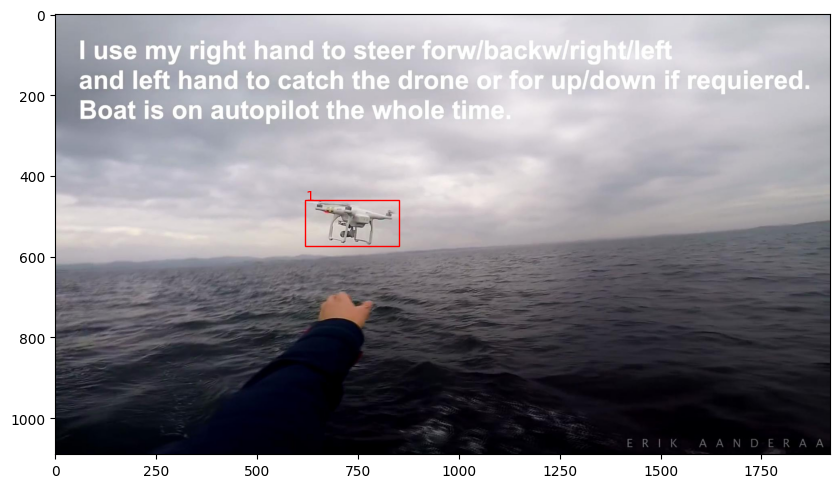

In [30]:
@torch.no_grad()
# Function to process images in a directory and plot the predictions
def process_and_plot_results(model, image_path, device):
        image = transforms.ToTensor()(Image.open(image_path))
        
        model.eval()
        bounding_boxes = []
        label_predictions = []
        image_tensor = image.unsqueeze(0).to(device)
        prediction_results = model(image_tensor)
        for prediction in prediction_results:
            bounding_boxes.append(prediction['boxes'].cpu().numpy())
            label_predictions.append(prediction['labels'].cpu().numpy())
        
        draw_bounding_boxes(image.permute((1, 2, 0)).cpu().numpy(), bounding_boxes, label_predictions)


process_and_plot_results(model,file_list_val[0] ,device)

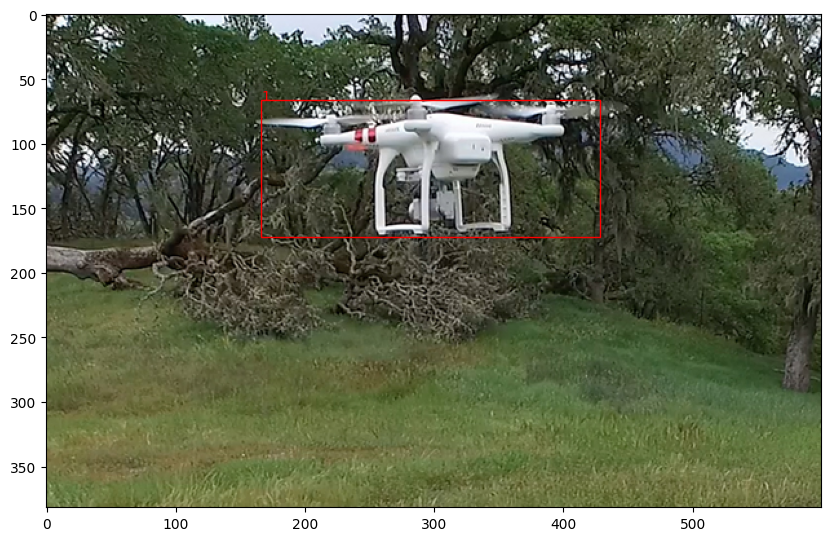

In [31]:
process_and_plot_results(model,file_list_val[12] ,device)

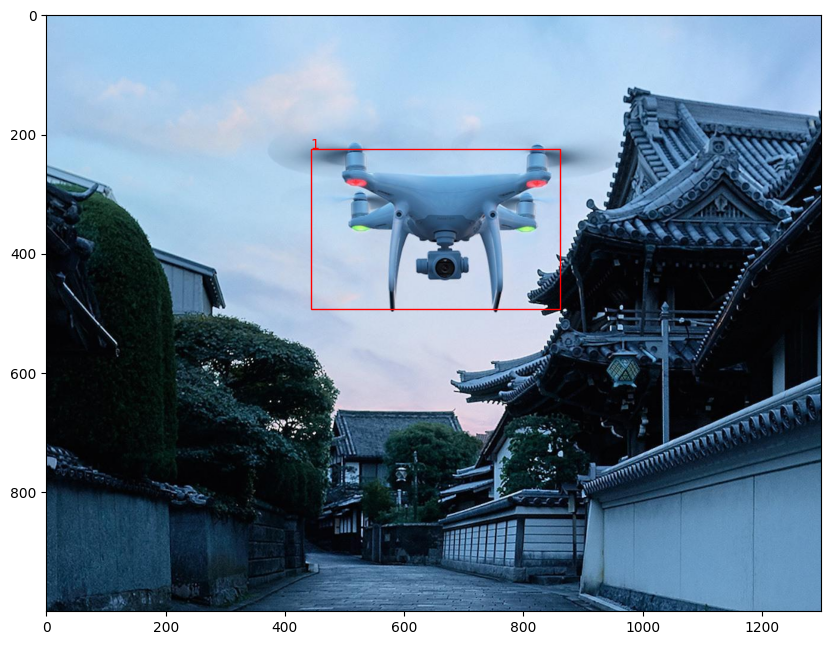

In [32]:
process_and_plot_results(model,file_list_val[100] ,device)